# Beispiel 9: b) Nichtlineare Regression mit dem Gauß-Newton-Verfahren

Wir betrachten nun einen weiteren Datensatz (Quelle: M. A. Treloar: “Effects
of Puromycin on Galactosyltransferase of Golgi Membranes” nach: D.M Bates & D.G. Watts: "Nonlinear Regression Analysis and Its Applications", Wiley & Sons, 1988).

Dabei geht es um eine Substrat-vermittelte Reaktion:
$$ P + S \rightarrow E$$
Die Geschwindigkeit dieser Reaktion $v$ hängt von der Konzentration von $x=[S]$ ab.  

In [1]:
PuromycinData =[
0.02 76 67;
0.02 47 51;
0.06 97 84;
0.06 107 86;
0.11 123 98;
0.11 139 115;
0.22 159 131;
0.22 152 124;
0.56 191 144;
0.56 201 158;
1.10 207 160;
1.10 200 NaN];

In [2]:
# Shortcuts
xlin = linspace(0.0,1.1,51);
xconc = PuromycinData(:,1);
vtreated = PuromycinData(:,2);
vuntreated = PuromycinData(:,3);

In [3]:
available_graphics_toolkits()

ans = {
  [1,1] = gnuplot
  [1,2] = notebook
  [1,3] = plotly
}


In [4]:
# graphics_toolkit("notebook")
# %graphics_toolkit("gnuplot")
# %setenv("GNUTERM", "qt")
myColorFit = "#FF8800" # Orange
myColorExp = "#0000FF" # Blue

myColorFit = #FF8800


myColorExp = #0000FF


In [5]:
graphics_toolkit("plotly")

## Modellierung
Es wird angenommen, dass die Geschwindigkeit der Reaktion über eine Michaelis-Menten-Kinetik beschrieben werden kann:
$$ v(x) = \frac{\theta_1 x}{ \theta_2 + x}
$$
Dabei sind die Modell-Parameter $\theta_1$, $\theta_2$ zu bestimmen. Die Größe $x$ ist die experimentell verwendete Substrat-Konzentration. 

In [6]:
function fval = MichaelisMenten(x, theta)
    fval = (theta(1).*x)./(theta(2) + x);
endfunction

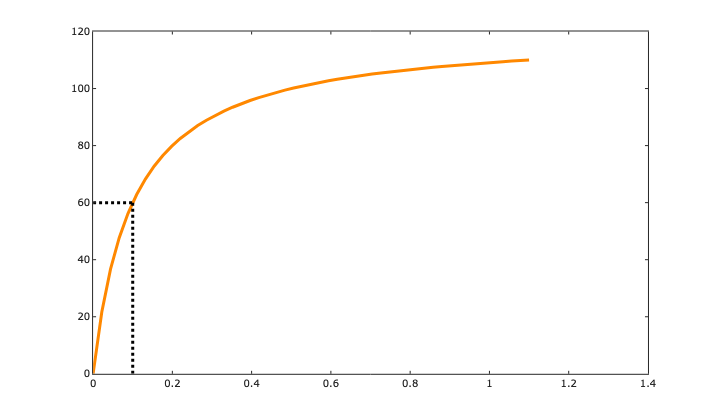

    axes at line 107 column 8
    newplot at line 161 column 10
    plot at line 234 column 9
    cell[7] at line 3 column 1



In [7]:
vapprox = MichaelisMenten(xlin, [120,0.1]);
clf;
plot(xlin, vapprox, "-", "linewidth", 3, "color", myColorFit);
line([0 0.1], [60 60], "linestyle", ":", "color", "k", "linewidth", 3);
line([0.1 0.1], [0 60], "linestyle", ":", "color", "k", "linewidth", 3);

## Daten

In [8]:
theta0 = [120, 0.4]
#theta0 = [300, 0.5]

theta0,1,2
1,120,0.4


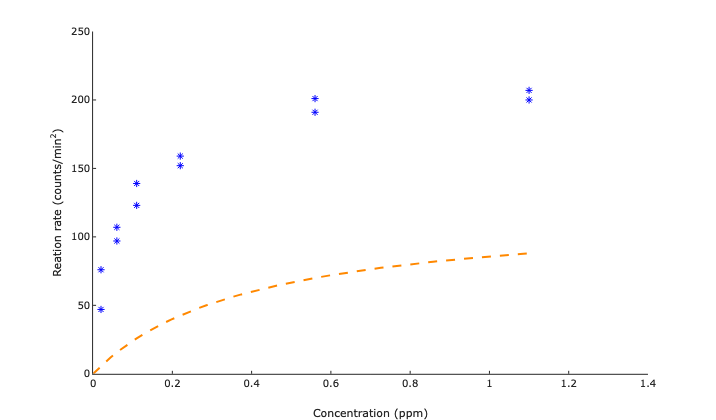

In [9]:
vapprox = MichaelisMenten(xlin, theta0 );

hold on

xlabel("Concentration (ppm)")
ylabel("Reation rate (counts/min^2)")

plot(xconc, vtreated, "*", "linewidth", 2, "color", myColorExp)

#plot(xconc, vuntreated, "+", "linewidth", 2, "color", myColorExp)
plot(xlin, vapprox, "--", "linewidth", 2,  "color", myColorFit)


#legend("Messung");

#legend("Messung A", "Messung B", "Modell");

## Gauß-Newton-Verfahren

Die Ableitungen $\frac{\partial f}{\partial \theta_i}(x, \theta)$ sollen numerisch bestimmt werden:

In [10]:
function fprime = num_deriv(f, i, x, theta)
    eps = 1e-8;
    delta = zeros(size(theta));
    delta(i) = abs(theta(i)*eps);
    deltaf = f(x,theta+delta) - f(x,theta);
    fprime = deltaf/abs(delta(i));
endfunction

Definiere Hilfsfunktion zur Liniensuche:

In [11]:
function jopt=LineSearch(f,x,y, mytheta, mydelta, lambda)
    jopt=1;
    obj_opt=1e+60;
    % disp ("=== LS:")
    % mytheta
    % mydelta
    
    for j=1:length(lambda)
        % j
        tentative = mytheta + lambda(j)*mydelta;
        r = f(x, tentative) - y;
        
        obj = norm (r);
        obj =obj*obj;
        
        if (obj < obj_opt)
            jopt = j;
            obj_opt = obj;
        end 
    end
endfunction

Das Gauß-Newton-Verfahren bestimmt
$$\theta^{(k+1)} := \theta^{(k)} + \lambda \Delta$$
über 
$$ J^T J \Delta = -J^T r$$

In [12]:
function theta_opt = GaussNewton(f, x, y, theta0, nsteps)
   
    % Startwert
    mytheta(1,:) = theta0;

    % Parameter fuer Liniensuche
    lambda = [1 0.5 0.25 0.125 0.0625 0.0625/2, 0]; 
    
    % Iteration
    for k=1:nsteps
    
        % Ausgabe
        disp ("==============================")
        k
        mytheta(end,:)
    
        % Berechne Residuum und dessen Norm.
        r = f(x, mytheta(end,:)) - y;
        obj = norm (r);
        obj =obj*obj
    
        % Berechne Jacobi-Matrix bzgl. der Parameter.
        J(:,1) = num_deriv(f, 1, x, mytheta(end,:));
        J(:,2) = num_deriv(f, 2, x, mytheta(end,:));

        # Abbruchkriterium
        myeps = norm(J'*r);

        % Berechne Abstiegsrichtung über Normalengleichung
        delta = linsolve(J'*J, -J'*r)'

        % Verbesserung 1: QR-Zerlegung
        % [Q, R] = qr (J);
        %q=Q'*r;       
        %delta=linsolve(R(1:2,1:2), -q(1:2))'
        %scJ=R(1,1)/R(2,2)

        % Verbesserung 2: Liniensuche zur Optimierung des Abstiegs.
        %j_opt = 1
        j_opt = LineSearch(f,x,y, mytheta(end,:), delta, lambda); 
    
        # Auswahl der naechsten Iterierten     
        mytheta(end+1,:) = mytheta(end,:) + lambda(j_opt)*delta;

        if (myeps < 1e-8) 
            break; 
        endif
        
    end % for nsteps

    % Rueckgabe
    theta_opt = mytheta;
end

### Resultate (Fall A) 
Fall A: Mit Puromycin (treated)

In [28]:
theta_optA = GaussNewton(@MichaelisMenten, xconc, vtreated, theta0, 10)

k = 1


ans,1,2
1,120,0.4


obj = 1.2787e+05


delta,1,2
1,-14.627,-1.9888


k = 2


ans,1,2
1,118.172,0.1514


obj = 8.3514e+04


delta,1,2
1,86.2044,-0.248391


k = 3


ans,1,2
1,161.274,0.0272043


obj = 9059.1


delta,1,2
1,43.0546,0.0260034


k = 4


ans,1,2
1,204.328,0.0532077


obj = 1419.3


delta,1,2
1,7.30336,0.00914083


k = 5


ans,1,2
1,211.632,0.0623486


obj = 1200.6


delta,1,2
1,0.933255,0.00158195


k = 6


ans,1,2
1,212.565,0.0639305


obj = 1195.5


delta,1,2
1,0.106841,0.000172147


k = 7


ans,1,2
1,212.672,0.0641027


obj = 1195.4


delta,1,2
1,0.0107488,1.68081e-05


k = 8


ans,1,2
1,212.683,0.0641195


obj = 1195.4


delta,1,2
1,0.00104038,1.62141e-06


k = 9


ans,1,2
1,212.684,0.0641211


obj = 1195.4


delta,1,2
1,0.000100505,1.56603e-07


k = 10


ans,1,2
1,212.684,0.0641213


obj = 1195.4


delta,1,2
1,9.59491e-06,1.48431e-08


theta_optA,1,2
1,120,0.4
2,118.172,0.1514
3,161.274,0.0272043
4,204.328,0.0532077
5,211.632,0.0623486
6,212.565,0.0639305
7,212.672,0.0641027
8,212.683,0.0641195
9,212.684,0.0641211
10,212.684,0.0641213


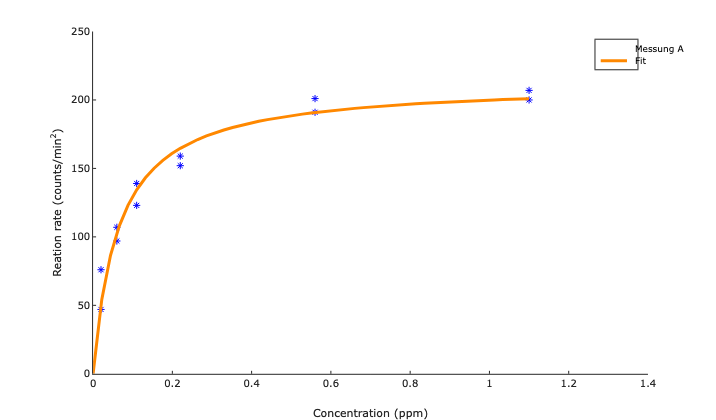

In [14]:
clf;
hold on
vapprox0 = MichaelisMenten(xlin, theta0);
vapprox = MichaelisMenten(xlin, theta_optA(end,:));

plot(xconc, vtreated, "*",  "color", myColorExp )
plot(xlin, vapprox, "-",  "linewidth", 3,  "color", myColorFit)
# plot(xlin, vapprox0, "--", "linewidth", 2,  "color", myColorFit)

#h=legend("Messung A", "Fit", "Start");
h=legend("Messung A", "Fit");
legend(h, "location", "northeast")

xlabel("Concentration (ppm)")
ylabel("Reation rate (counts/min^2)")

### Resultate (Fall B)
Ohne Puromycin (untreated)

In [15]:
theta_optB = GaussNewton(@MichaelisMenten, xconc(1:11), vuntreated(1:11), theta0, 10)

k = 1


ans,1,2
1,120,0.4


obj = 6.1421e+04


delta,1,2
1,-70.3206,-1.81021


k = 2


ans,1,2
1,111.21,0.173724


obj = 4.0700e+04


delta,1,2
1,32.2743,-0.361261


k = 3


ans,1,2
1,119.278,0.083409


obj = 1.8662e+04


delta,1,2
1,40.874,-0.0580859


k = 4


ans,1,2
1,160.152,0.0253231


obj = 3858.6


delta,1,2
1,-4.56388,0.0131205


k = 5


ans,1,2
1,155.589,0.0384436


obj = 1012.0


delta,1,2
1,3.45363,0.00714825


k = 6


ans,1,2
1,159.042,0.0455919


obj = 865.98


delta,1,2
1,1.02075,0.00177173


k = 7


ans,1,2
1,160.063,0.0473636


obj = 859.77


delta,1,2
1,0.184113,0.00029341


k = 8


ans,1,2
1,160.247,0.047657


obj = 859.61


delta,1,2
1,0.0281357,4.37e-05


k = 9


ans,1,2
1,160.275,0.0477007


obj = 859.60


delta,1,2
1,0.00413498,6.39644e-06


k = 10


ans,1,2
1,160.279,0.0477071


obj = 859.60


delta,1,2
1,0.000603561,9.33055e-07


theta_optB,1,2
1,120,0.4
2,111.21,0.173724
3,119.278,0.083409
4,160.152,0.0253231
5,155.589,0.0384436
6,159.042,0.0455919
7,160.063,0.0473636
8,160.247,0.047657
9,160.275,0.0477007
10,160.279,0.0477071


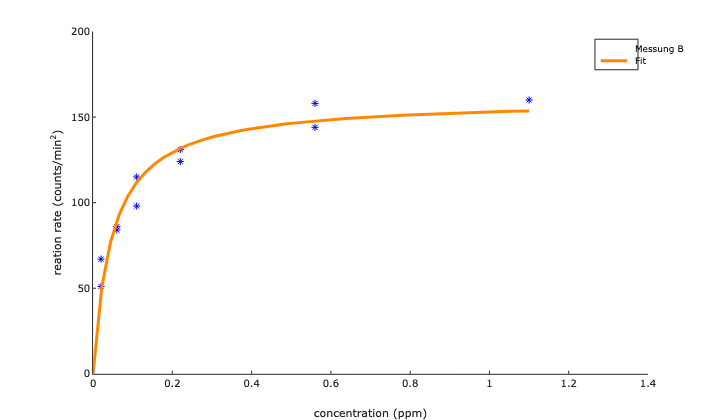

    legend>parse_opts at line 825 column 9
    legend at line 210 column 8
    cell[16] at line 10 column 2



In [16]:
hold on
vapprox0 = MichaelisMenten(xlin, theta0);
vapprox = MichaelisMenten(xlin, theta_optB(end,:));
plot(xconc, vuntreated, "*", "color", myColorExp)

plot(xlin, vapprox, "-", "linewidth", 3, "color", myColorFit)
# plot(xlin, vapprox0, "--", "linewidth", 3, "color", myColorFit)


h=legend("Messung B",  "Fit", "Ausgangsmodell");
legend(h, "location", "northeast")

title("Fall A: Behandelt")
xlabel("concentration (ppm)")
ylabel("reation rate (counts/min^2)")

### Vergleich der Parameter

In [17]:
theta_optA
theta_optB

theta_optA,1,2
1,120,0.4
2,118.172,0.1514
3,161.274,0.0272043
4,204.328,0.0532077
5,211.632,0.0623486
6,212.565,0.0639305
7,212.672,0.0641027
8,212.683,0.0641195
9,212.684,0.0641211
10,212.684,0.0641213


theta_optB,1,2
1,120,0.4
2,111.21,0.173724
3,119.278,0.083409
4,160.152,0.0253231
5,155.589,0.0384436
6,159.042,0.0455919
7,160.063,0.0473636
8,160.247,0.047657
9,160.275,0.0477007
10,160.279,0.0477071


## Darstellung der Minimierung

Wir betrachten die Energie:
$$\Phi(\theta) = \frac{1}{2} \|f(\theta) - y\|^2$$

In [18]:
function energy = EnergyPhi(y, f, theta)
    energy = norm(f(theta)-y, 2);
    energy = 0.5*energy*energy;
end 

In [19]:
EnergyPhi(vtreated, @(theta) MichaelisMenten(xconc, theta), theta_optA(end,:))

ans = 597.72


In [20]:
# Berechne Energielandschaft
tx = linspace (0.0, 400.0, 41)';
ty = linspace (0.0, 0.5, 41)';
[xx, yy] = meshgrid (tx, ty);

for i=1:length(tx)
for j=1:length(ty)
    thetaij =[xx(i,j), yy(i,j)];
    tz(i,j) = EnergyPhi(vtreated, @(theta) MichaelisMenten(xconc, theta), thetaij);
endfor
endfor

In [21]:
# Berechne Energie fuer Messdaten 
in=theta_optA(:,1:2);
energies = zeros(size(in(:,1)));
for i=1:size(energies)(1)
    energies(i) = EnergyPhi(vtreated, @(theta) MichaelisMenten(xconc, theta), in(i,:));
endfor
energies;

### Graphische Darstellung

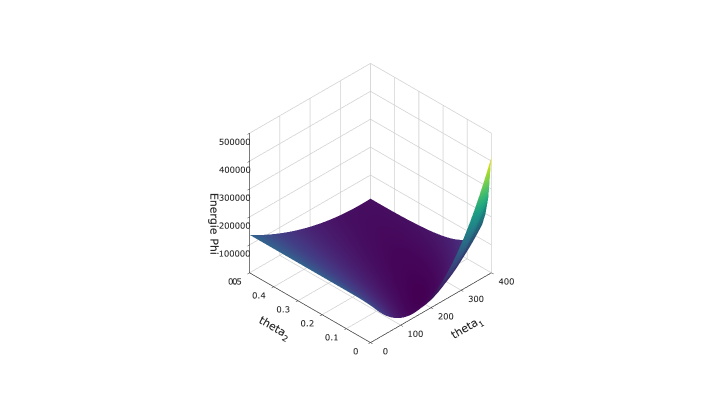

In [22]:
# Graphische Darstellung
graphics_toolkit("plotly")
#plot3(theta_optA(:,1), theta_optA(:,2), energies);
mesh (tx, ty, tz);
title("Energy landscape")
xlabel "theta_1"
ylabel "theta_2"
zlabel("Energie Phi")


### Darstellung in der Parameter-Ebene

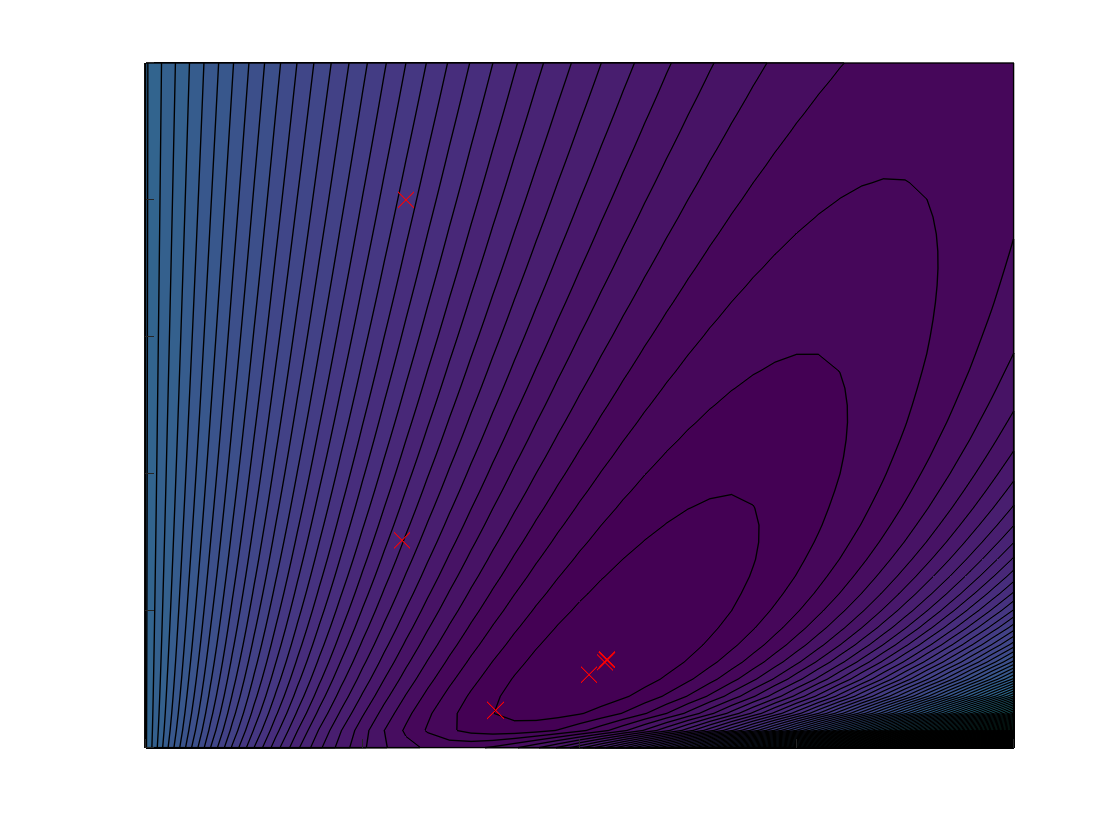

In [23]:
# Darstellung in der Parameter-Ebene
graphics_toolkit("notebook")
hold on
contourf (tx, ty, tz, 101)
plot(theta_optA(:,1),theta_optA(:,2), "x", "color", "#FF0000")
%h=legend("Messung", "Ausgangsmodell", "Fit");
%legend(h, "location", "north")

%xlabel "theta_1"
%ylabel "theta_2"
graphics_toolkit("plotly")

### Konvergenzordnung
Beobachtet wird eine lineare Konvergenz:

In [24]:
norm(theta_optA(2,:) - theta_optA(1,:))
norm(theta_optA(3,:) - theta_optA(2,:))
norm(theta_optA(4,:) - theta_optA(3,:))
# Bis hierher Liniensuche...
norm(theta_optA(5,:) - theta_optA(4,:))
norm(theta_optA(6,:) - theta_optA(5,:))
norm(theta_optA(7,:) - theta_optA(6,:))
norm(theta_optA(8,:) - theta_optA(7,:))
norm(theta_optA(9,:) - theta_optA(8,:))

ans = 1.8452


ans = 43.102


ans = 43.055


ans = 7.3034


ans = 0.9333


ans = 0.1068


ans = 0.010749


ans = 1.0404e-03


## Gradientenverfahren

In [25]:
function theta_opt = GradientMethod(f, x, y, theta0, nsteps)
   
    % Startwert
    mytheta(1,:) = theta0;

    % Parameter zur Liniensuche
    lambda = [1 0.5 0.25 0.125 0.0625 0.0625/2, 0.0625/8, 0.0625/64, 0.0625/256, 0.0625/1024,  0.0625/4096, 0.0625/(4*4096),1e-8 , 1e-10 , 1e-12]
     
    % Iteration
    for k=1:nsteps
    
        % Ausgabe
        disp ("==============================")
        disp ("Iteration")
      
        % Residuum
        r = f(x, mytheta(end,:)) - y; 

        % Jacobi-Matrix bzgl. theta
        J(:,1) = num_deriv(f, 1, x, mytheta(end,:));
        J(:,2) = num_deriv(f, 2, x, mytheta(end,:));
    
        % Berechne neg. Gradienten als Abstiegsrichtung 
        grad = -(J'*r)'
        mytheta(end,:);
    
        % Liniensuche (zur Optimierung des Abstiegs(. 
        j_opt = LineSearch(f,x,y, mytheta(end,:), grad, lambda) 
    
        # Auswahl der naechsten Iterierten
        disp ("Optimal: ")
        #obj_opt 
        mytheta(end+1,:) = mytheta(end,:) + lambda(j_opt)* grad;
    end % for nsteps

    theta_opt = mytheta;
end

In [26]:
theta_optA = GradientMethod(@MichaelisMenten, xconc, vtreated, theta0,5)

lambda,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,1,0.5,0.25,0.125,0.0625,0.03125,0.0078125,0.000976562,0.000244141,6.10352e-05,1.52588e-05,3.8147e-06,1e-08,1e-10,1e-12


Iteration


grad,1,2
1,469.72,-65500.8


j_opt = 12


Optimal: 
Iteration


grad,1,2
1,549.938,-137257


j_opt = 13


Optimal: 
Iteration


grad,1,2
1,550.318,-138021


j_opt = 13


Optimal: 
Iteration


grad,1,2
1,550.696,-138797


j_opt = 13


Optimal: 
Iteration


grad,1,2
1,551.072,-139585


j_opt = 13


Optimal: 


theta_optA,1,2
1,120,0.4
2,120.002,0.150134
3,120.002,0.148762
4,120.002,0.147381
5,120.002,0.145993
6,120.002,0.144598


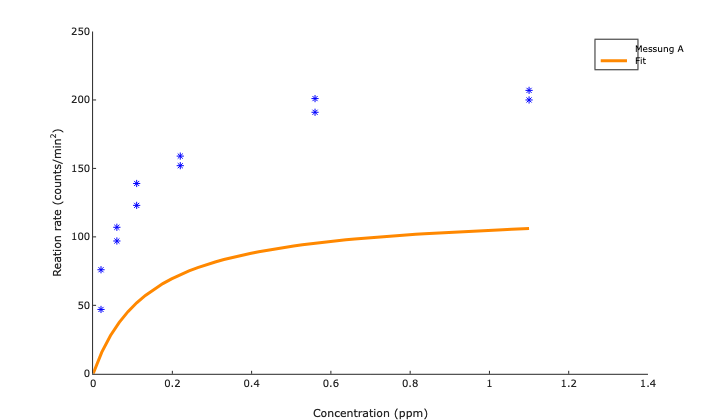

In [27]:
clf;
hold on
vapprox0 = MichaelisMenten(xlin, theta0);
vapprox = MichaelisMenten(xlin, theta_optA(end,:));

plot(xconc, vtreated, "*",  "color", myColorExp )
plot(xlin, vapprox, "-",  "linewidth", 3,  "color", myColorFit)
# plot(xlin, vapprox0, "--", "linewidth", 2,  "color", myColorFit)

#h=legend("Messung A", "Fit", "Start");
h=legend("Messung A", "Fit");
legend(h, "location", "northeast")

xlabel("Concentration (ppm)")
ylabel("Reation rate (counts/min^2)")